## Final Project: Board Game Analysis


The dataset I'll be analyzing contains scraped data from the website BoardGameGeek. The dataset should contain information on the various games that have earned enough user ratings on the website (30+ ratings). I'll be looking into Clustering and looking for any patterns, as well training a model to predict user ratings with the available features.

Source: https://www.kaggle.com/datasets/andrewmvd/board-games

In [268]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

### Part 1: Data Importing and EDA

First start by importing the data from the csv.

In [242]:
# Importing the data

df = pd.read_csv('bgg_dataset.csv', sep=';')
print(df.info())
print(df.columns)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20343 entries, 0 to 20342
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  20327 non-null  float64
 1   Name                20343 non-null  object 
 2   Year Published      20342 non-null  float64
 3   Min Players         20343 non-null  int64  
 4   Max Players         20343 non-null  int64  
 5   Play Time           20343 non-null  int64  
 6   Min Age             20343 non-null  int64  
 7   Users Rated         20343 non-null  int64  
 8   Rating Average      20343 non-null  object 
 9   BGG Rank            20343 non-null  int64  
 10  Complexity Average  20343 non-null  object 
 11  Owned Users         20320 non-null  float64
 12  Mechanics           18745 non-null  object 
 13  Domains             10184 non-null  object 
dtypes: float64(3), int64(6), object(5)
memory usage: 2.2+ MB
None
Index(['ID', 'Name', 'Year Published', '

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,"8,79",1,"3,86",68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,"8,61",2,"2,84",65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517.0,Brass: Birmingham,2018.0,2,4,120,14,19217,"8,66",3,"3,91",28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791.0,Terraforming Mars,2016.0,1,5,120,12,64864,"8,43",4,"3,24",87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078.0,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,"8,70",5,"4,22",16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"


There's a few things I note off the bat from looking at the first few rows: 
1. Some of the data types weren't imported right. Complexity Average and Rating Average should be converted to floats, ID, Year Published, and Owned Users to Integers.
2. Mechanics and Domains can contain multiple tags/categories in each column, so I'll need to factor that in somehow.
3. Some degree of scaling might be needed if I'm using any distance based models (Owned Users and Users rated are significantly larger than anything else).

Before I do all that, I want to handle null values first though.

#### Removing NaN values
Looking at the data, there's a lot of games with blank Mechanics and Domains. These should probably still be kept since they're still otherwise valid and it's a pretty big chunk of the data. I'll replace the Nan values later when I split those columns into multi-categories.

I will probably remove the ones with missing IDs and Owned Users data though, since it's a small enough subset to not matter much.

In [243]:
na_count = df.isna().sum()

print(na_count)

ID                       16
Name                      0
Year Published            1
Min Players               0
Max Players               0
Play Time                 0
Min Age                   0
Users Rated               0
Rating Average            0
BGG Rank                  0
Complexity Average        0
Owned Users              23
Mechanics              1598
Domains               10159
dtype: int64


In [244]:
df = df.dropna(subset=['ID', 'Owned Users'])
print(df.isna().sum())

ID                        0
Name                      0
Year Published            0
Min Players               0
Max Players               0
Play Time                 0
Min Age                   0
Users Rated               0
Rating Average            0
BGG Rank                  0
Complexity Average        0
Owned Users               0
Mechanics              1581
Domains               10136
dtype: int64


#### Converting Data types
Changing column types to int and float as mentioned earlier.

In [245]:
# Changing columns to int
df = df.astype({"Owned Users": int, "Year Published": int, "ID": int})

# Changing decimal strings to floats
df['Rating Average'] = df['Rating Average'].replace(',', '.', regex=True).astype(float)
df['Complexity Average'] = df['Complexity Average'].replace(',', '.', regex=True).astype(float)

df.head()

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430,Gloomhaven,2017,1,4,120,14,42055,8.79,1,3.86,68323,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936,Pandemic Legacy: Season 1,2015,2,4,60,13,41643,8.61,2,2.84,65294,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517,Brass: Birmingham,2018,2,4,120,14,19217,8.66,3,3.91,28785,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791,Terraforming Mars,2016,1,5,120,12,64864,8.43,4,3.24,87099,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078,Twilight Imperium: Fourth Edition,2017,3,6,480,14,13468,8.70,5,4.22,16831,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"


#### Checking for Dupes
Next, I want to make sure there's no duplicate data. I'm mainly checking the ID, Name, and Year Published columns for this.

In [246]:
print("Duplicate ID count: " + str(df['ID'].duplicated().sum()))
print("Duplicate Name count: " + str(df['Name'].duplicated().sum()))
print("Duplicate Name + Year count: " + str(df.duplicated(subset=['Name', 'Year Published'], keep=False).sum()))

Duplicate ID count: 0
Duplicate Name count: 367
Duplicate Name + Year count: 12


Even though there's quite a few duplicate names (367), I can't discount that there might be multiple board games sharing a name or multiple versions of the same game. So I'll only delete the entries that share both Name and Year. There weren't any duplicate IDs, so I don't need to worry about that.

In [247]:
print(df.shape)
df = df.drop_duplicates(subset=['Name', 'Year Published'])
print(df.shape)

(20320, 14)
(20314, 14)


Now that I've dropped the duplicates, I'll probably drop the ID and Name column as well. It's unlikely to be an important feature for any of the models, and being a non-numeric value might overcomplicate things in the case of Name.

In [248]:
df = df.drop(['ID', 'Name'], axis=1)

#### Handling Mechanic and Domain Columns
This one's a bit trickier to handle. For one, besides the name column they're the only non-numerical columns, so if I want to do something like NMF, I'll either need to cut the columns completely, or convert them to numbers. I also have the option to just remove the columns entirely, but it feels like there's quite a bit of info stored in these columns, so I'd rather not. 

I'll start by getting the # of unique values in Mechanics and Domain (without factoring in combinations).

In [249]:
domain_u = df['Domains'].nunique()
print("Unique Domains: " + str(domain_u))

mech_u = df['Mechanics'].nunique()
print("Unique Mechanics: " + str(mech_u))

Unique Domains: 39
Unique Mechanics: 7377


If the number of unique combinations for Mechanics/Domains was small enough, I considered just ignoring it and just treat combinations as their own unique value, and that might work for the Domains column, but the number of Unique combinations of Mechanics is probably too large to ignore.

As a solution, I'll use the MultiLabelBinarizer from sklearn to apply one-hot encoding, which should change the categories to numerical values, and split each category into its own column. This will increase the dimensionality of the data, but should provide useful information for the models to train on.

In [250]:
# Splitting Domains
df['Domains'] = df['Domains'].fillna('Unknown Domain')
df['Domains'] = df['Domains'].apply(lambda x: [y.strip() for y in str(x).split(',')])
mlb_d = MultiLabelBinarizer()
df_domain_encoded = pd.DataFrame(mlb_d.fit_transform(df['Domains']), columns=mlb_d.classes_, index=df.index)
df = pd.concat([df, df_domain_encoded], axis=1)

df = df.drop('Domains', axis=1)

df.columns

Index(['Year Published', 'Min Players', 'Max Players', 'Play Time', 'Min Age',
       'Users Rated', 'Rating Average', 'BGG Rank', 'Complexity Average',
       'Owned Users', 'Mechanics', 'Abstract Games', 'Children's Games',
       'Customizable Games', 'Family Games', 'Party Games', 'Strategy Games',
       'Thematic Games', 'Unknown Domain', 'Wargames'],
      dtype='object')

In [251]:
# Splitting Mechanics
df['Mechanics'] = df['Mechanics'].fillna('Unknown Mechanic')
df['Mechanics'] = df['Mechanics'].apply(lambda x: [y.strip() for y in str(x).split(',')])
mlb_m = MultiLabelBinarizer()
df_mechanic_encoded = pd.DataFrame(mlb_m.fit_transform(df['Mechanics']), columns=mlb_m.classes_, index=df.index)
df = pd.concat([df, df_mechanic_encoded], axis=1)

df = df.drop('Mechanics', axis=1)

df.columns

Index(['Year Published', 'Min Players', 'Max Players', 'Play Time', 'Min Age',
       'Users Rated', 'Rating Average', 'BGG Rank', 'Complexity Average',
       'Owned Users',
       ...
       'Turn Order: Stat-Based', 'Unknown Mechanic', 'Variable Phase Order',
       'Variable Player Powers', 'Variable Set-up',
       'Victory Points as a Resource', 'Voting', 'Worker Placement',
       'Worker Placement with Dice Workers', 'Zone of Control'],
      dtype='object', length=202)

In [252]:
print("Total Mechanics: " + str(len(mlb_m.classes_)))
print("Total Domains: " + str(len(mlb_d.classes_)))

Total Mechanics: 183
Total Domains: 9


#### Plotting out Histograms for Mechanics and Domains
Just looking at the overall distribution of Mechanics and Domains. Note that there's some overlap since a game can have multiple mechanics/domains.

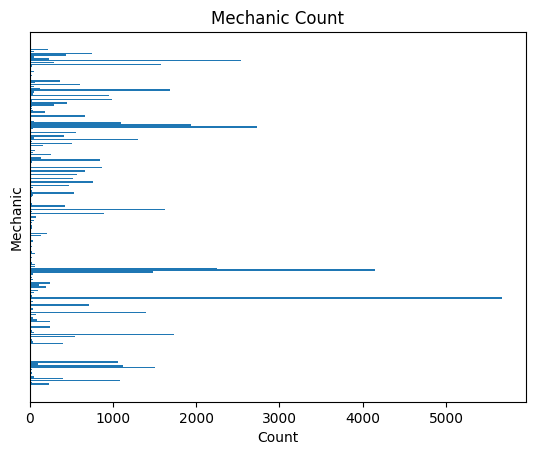

In [253]:
mechanic_sum = df[mlb_m.classes_].sum()

plt.barh(mechanic_sum.index, mechanic_sum)
plt.title('Mechanic Count')
plt.xlabel('Count')
plt.ylabel('Mechanic')
plt.yticks([])

plt.show()

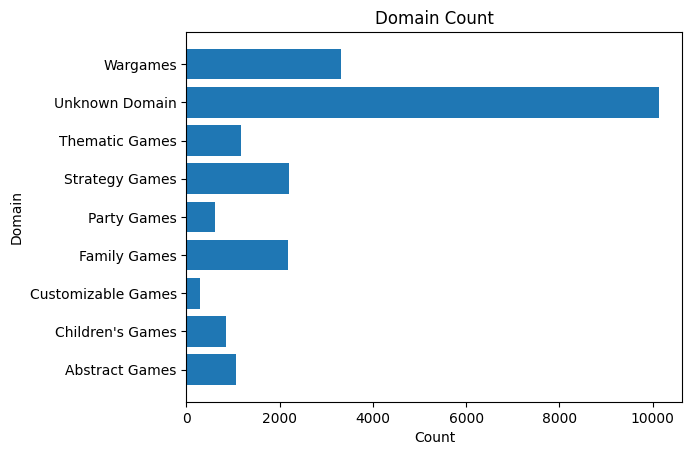

In [254]:
domain_sum = df[mlb_d.classes_].sum()

plt.barh(domain_sum.index, domain_sum)
plt.title('Domain Count')
plt.xlabel('Count')
plt.ylabel('Domain')

plt.show()

I'm a little concerned that the Unknown Domain (the NaN replacement value) might skew the data as an outlier, but it's a bit awkward to cut too, so I'll leave it in and see how it affects things.

#### Score Distribution
I also want to see how scores are distributed on average. It seems like a bell curve with most scores situated between 6-7.

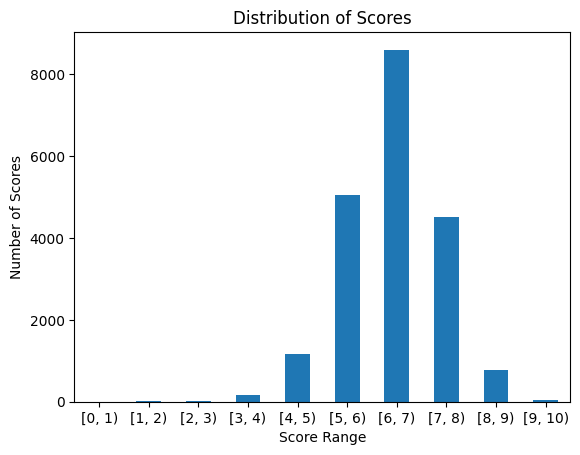

In [255]:
bins = range(0, 11)
rate_range = pd.cut(df['Rating Average'], bins=bins, right=False)

score_counts = rate_range.value_counts().sort_index()

score_counts.plot(kind='bar')
plt.title('Distribution of Scores')
plt.xlabel('Score Range')
plt.ylabel('Number of Scores')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
plt.show()

#### Other Columns

#### Scaling Data
Since some of the models like NMF will want the data scaled first since they're sensitive to magnitude differences between features.

In [263]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

#print(scaled_df)

[[  0.1530811   -1.47639551  -0.10980043 ...  -0.19565952  -0.04967323
   -0.10630542]
 [  0.14374156  -0.02837029  -0.10980043 ...  -0.19565952  -0.04967323
   -0.10630542]
 [  0.15775087  -0.02837029  -0.10980043 ...  -0.19565952  -0.04967323
   -0.10630542]
 ...
 [ -0.16446335  -0.02837029  -0.10980043 ...  -0.19565952  -0.04967323
   -0.10630542]
 [-10.199802    -0.02837029   0.02142006 ...  -0.19565952  -0.04967323
   -0.10630542]
 [-15.3365505   -0.02837029  -0.24102093 ...  -0.19565952  -0.04967323
   -0.10630542]]


### Part 2: Unsupervised Learning using NMF
After splitting the Mechanic and Domain columns, all columns are now numerical (besides Name, which can probably just be dropped), so we can try using Non-negative Matrix Factorization (NMF) to create a model and see how well it can predict missing user ratings.

There's not really a goal in terms of how many components I'm expecting, so I might tune that as a hyperparameter.

In [ ]:
#Random
model = NMF(n_components=3, init='random', random_state=0, max_iter=500)
W_rand = model.fit_transform(train_matrix)
H_rand = model.components_

prediction = np.dot(W_rand, H_rand)
# predict_df = pd.DataFrame(prediction, index=MV_users['uID'], columns=MV_movies['mID'])

### Part 3: Unsupervised Learning using KMeans Clustering (if Applicable?)
Since we have a wide number of features, we can potentiallyK means clustering (sklearn.cluster.KMeans), Dimensionality reduction with PCA?

### Part 4: Trying Supervised Learning (Trees or Clusters?)
When we include the Domains and Mechanics columns (split into multiple columns), we have a relatively high number of features in this data set. Since we're trying to predict the Average Rating, we'll need to use regression models. As such, it makes sense to use methods like Random Forest or <> which can handle high feature count/dimensionality better.

Unlike Unsupervised, I actually need to split the data first into training/test splits since it'll overfit otherwise.

In [264]:
from sklearn.model_selection import train_test_split
X = df.drop(['Rating Average'], axis=1)
y = df['Rating Average']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=32)
print(y_train.shape)

(6094,)


#### Supervised 1: Linear Regression

In [272]:
from sklearn.linear_model import LinearRegression

#Try different hyperparameters
lr_clf = LinearRegression().fit(X_train, y_train)

print("Linear Regression Training Score: " + str(lr_clf.score(X_train, y_train)))
print("Linear Regression Test Score: " + str(lr_clf.score(X_test, y_test)))

Linear Regression Training Score: 0.6920708624256382
Linear Regression Test Score: 0.6564866103396962


In [ ]:
Somewhat weak score

In [ ]:
 # Confusion Matrix, not really applicable for regression tests

#cm = confusion_matrix(test, pred)
#cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# cm_disp.plot()
# plt.show()

In [ ]:
train_y = df_train['Category']

lr_model = LogisticRegression().fit(tfidf, train_y)

train_y_pred = lr_model.predict(tfidf)
lr_acc = accuracy_score(train_y, train_y_pred)

#### Conclusions